In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/Colab Notebooks/Assignment 1'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from matplotlib import pyplot as plt
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
# modify to change function of the program
# q1 : Apply both Canny Edge Detection and Sobel Edge Detection
# q2 : Perform blurring of only faces
# q3 : Calculating the number of coins in an image using contours
# default : bounding box for face

mode="q3" 

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))

  # get OpenCV format image
  img = js_to_image(data) 

  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
 
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  
  # draw face bounding box on image
  for (x,y,w,h) in faces:

  # initialize only_face to face area that is detected by Haar Cascade
    only_face = img[y:y+h,x:x+w] 

    if mode=="q1":
      # passes only_face to Canny edge detection with a (low,high) threshold of (120,150)
      img_canny = cv2.Canny(only_face,120,150)
      # passes img_canny to Sobel edge detection with a kernel size of 1
      sobelx = cv2.Sobel(img_canny, cv2.CV_8U,1,0,ksize=-1)
      sobely = cv2.Sobel(img_canny, cv2.CV_8U,0,1,ksize=-1)
      # merge both sobel edge detection for x and y into img_sob
      img_sob = sobelx + sobely
      # convert the img sobel edge detection to RGB to make it the same dimension as img
      img_sobel = cv2.cvtColor(img_sob, cv2.COLOR_GRAY2RGB)
      # merge img_sobel on top of img obtained from captured camera  
      img[y:y+img_sobel.shape[0], x:x+img_sobel.shape[1]] = img_sobel
    
    elif mode=="q2":
      # passes only_face to Gaussian blur with a kernel size of 15x15 and sigmaX of 30
      img_blur = cv2.GaussianBlur(only_face,(15,15),30)
      # merge img_blur on top of img obtained from captured camera  
      img[y:y+img_blur.shape[0], x:x+img_blur.shape[1]] = img_blur
    
    elif mode=="q3":
      # post processing is done to enable easier detection of contours
      # passes gray to Gaussian blur with a kernel size of 11x11
      img_blur = cv2.GaussianBlur(gray,(11,11), 0)
      # passes img_blur for canny edge detection with a (low,high) threshold of (30,60)
      img_canny = cv2.Canny(img_blur,30, 60)
      # dilate img_canny to make the edges produced by the canny edge detection to be thicker
      dilate = cv2.dilate(img_canny , (1, 1), iterations=2)
      # find contours with the image of dilate
      (cnt, heirarchy) = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
      
      # draw the contours to img
      img=cv2.drawContours(img, cnt, -1, (0,255,0), 2)
      # prints the amount of countours found
      print('Coins in the image: ', len(cnt))

    else :
      # if mode is anything else than q1,q2 or q3, run bounding box command
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    # save image
    cv2.imwrite(filename, img)

    return filename

<IPython.core.display.Javascript object>

Coins in the image:  5
Saved to photo.jpg


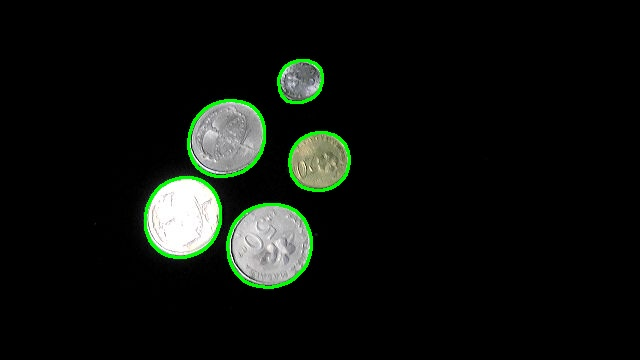

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
  
  #1917197